## Diffusive Shock Acceleration (DSA)

In DSA - or First Order Fermi Acceleration - charged particles experience energy gain when they (repeatedly) cross a moving shock front. At non-relativistic, stationary, ideal shocks, neglecting backreaction of particles to the background plasma, the energy spectrum is a power-law, only depending on the shocks compression ratio $q = u_{\mathrm{up}}/ u_{\mathrm{down}}$. For a strong shock with compression $q = 4$, the expected spectral slope is $-2$.

In the diffusive picture, DSA comes from adiabatic heating due to the changing advection field, $\nabla \vec{u} \neq 0$. An infinitly thin shock can not be modeled, instead the shock profile is smoothed, e.g. in 1D $u(x) \propto \mathrm{tanh}(x/L_{\mathrm{sh}})$. The shock width $L_{\mathrm{sh}}$ now implies constraints on the diffusion coefficient $\kappa$ and time step $\Delta t$ of the simulation: 

1. The (average) diffusive step $\sqrt{\kappa \Delta t}$ must be higher than the shock width $L_{\mathrm{sh}}$. 
   1. If diffusion is too small, (pseudo-)particles do not make it back over the shock and there is (almost) no acceleration
   2. If the shock width is too large compared to the diffusive step, a smooth velocity gradient is modeled instead of a real shock. This leads to steeper energy-spectra compared to the ideal shock
2. The advective step $\left(u + \partial \kappa(x)/\partial x \right)\Delta t$ must be smaller than the shock width $L_{\mathrm{sh}}$. 
   1. If advection is too high, the probability that pseudo-particles encounter the changing advection field is too low. With that acceleration is underestimated, leading to steeper spectra. 
   2. The drift term due to changing diffusion coefficients, pushes pseudo-particles away from the shock. In the following we assume spatially constant diffusion

In [1]:
%matplotlib inline
from crpropa import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Simple set-up for DSA at a 1D shock:

In [2]:
#Parameters

#Shock profile:
compression = 4
v_up = 1 #upstream velocity in m/s
l_sh = 0.02 #shock width in m
adv = OneDimensionalCartesianShock(compression, v_up, l_sh) #shock profile

#Adiabatic Cooling for particle acceleration:
ac = AdiabaticCooling(adv)

#Diffusion: 
kappa = 1 #diffusion coefficient in m^2/s
epsilon = 0 #parallel diffusion only
alpha = 0 #energy-independent diffusion

Bfield = UniformMagneticField(Vector3d(1*nG,0*nG,0*nG)) #parallel to advective field

delta_t = 0.005 #simulation time step in s. So that, advective step < shock width < diffusive step

minStep = delta_t * c_light 
maxStep = minStep #no adaptive step length
precision = 1e-3
diffSDE = DiffusionSDE(Bfield, adv, precision, minStep, maxStep, epsilon)

diffSDE.setAlpha(alpha)
diffSDE.setScale(kappa/(6.1*10**24)) #scaling in DiffusionSDE: kappa = scale * (6.1*10**24) * (R/4GV)^alpha

#Source: 
E0 = TeV 
Id = nucleusId(1,1)
src_pos = 0 #candidates injected at the shock

source = Source()
source.add(SourcePosition(Vector3d(src_pos, 0, 0)))
source.add(SourceParticleType(Id))
source.add(SourceEnergy(E0))
source.add(SourceIsotropicEmission())

#Time Observer to construct stationary solution:
T_min = delta_t
T_max = 200+delta_t
n_time = 200 # approximation of stationary solution depends on number of candidates, simulation time step AND "observing" time step

#simulate until T_max is reached, no escape boundaries in space:
maxTra = MaximumTrajectoryLength( T_max * c_light)

N_cand = 10**4 #number of simulated pseudo-particles

In [3]:
#Simulation

file = "SimpleDSA.txt"
outTime = TextOutput(file)
outTime.setEnergyScale(TeV)
outTime.setLengthScale(meter)
outTime.disableAll()
outTime.enable(Output.TrajectoryLengthColumn)
outTime.enable(Output.CurrentEnergyColumn)
outTime.enable(Output.CurrentPositionColumn)

obsTime = Observer()
obsTime.add(ObserverTimeEvolution(T_min*c_light, T_max*c_light, n_time, False)) 
obsTime.onDetection(outTime)
obsTime.setDeactivateOnDetection(False)


m = ModuleList()
m.add(diffSDE)
m.add(ac)
m.add(obsTime)
m.add(maxTra)
m.setShowProgress(True)
m.run(source, N_cand)
outTime.close()

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Fri Nov  3 10:12:36 2023 : [ Finished ] 100%    Needed: 00:00:37  - Finished at Fri Nov  3 10:13:13 2023


In [4]:
columns = ['D', 'E', 'X', 'Y', 'Z']
file = "SimpleDSA.txt"
df = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df["T"] = df["D"]/(c_light)

In [5]:
def energy_spectrum(df, bins, weighted = False):
    # calculates the energy spectrum J, dJ of dataframe df
    # returns touple (N, dN, bin_center)
    # weights are taken into account if weighted == True

    if weighted:
        HW = np.histogram(df['E'], bins = bins, weights = df["W"])
    H = np.histogram(df['E'], bins = bins)

    bin_edges = H[1]
    bin_width = bin_edges[1:] - bin_edges[:-1]
    bin_center = bin_edges[:-1] + 0.5 * bin_width

    if weighted:
        J = HW[0]/bin_width
        dJ = J/np.sqrt(H[0]) 
    else:
        J = H[0]/bin_width
        dJ = np.sqrt(H[0])/bin_width  

    return J,  dJ, bin_center

def number_density(df, bins, weighted = False):
    # calculates the number density integrated over energy N, dN of dataframe df
    # returns touple (N, dN, bin_center)
    # weights are taken into account if weighted == True

    if weighted:
        HW = np.histogram(df['X'], bins = bins, weights = df["W"])
    H = np.histogram(df['X'], bins = bins)

    bin_edges = H[1]
    bin_width = bin_edges[1:] - bin_edges[:-1]
    bin_center = bin_edges[:-1] + 0.5 * bin_width

    if weighted:
        N = HW[0]/bin_width
        dN = N/np.sqrt(H[0]) 
    else:
        N = H[0]/bin_width
        dN = np.sqrt(H[0])/bin_width  

    return N,  dN, bin_center


### Burst-like Injection at the Shock

Pseudo-particles are injected at the shock at $t = 0$ and propagated until the maximum simulation time $T = 200$. We plot the energy-spectrum at the shock and number density (integrated over energy) in the acceleration region over time

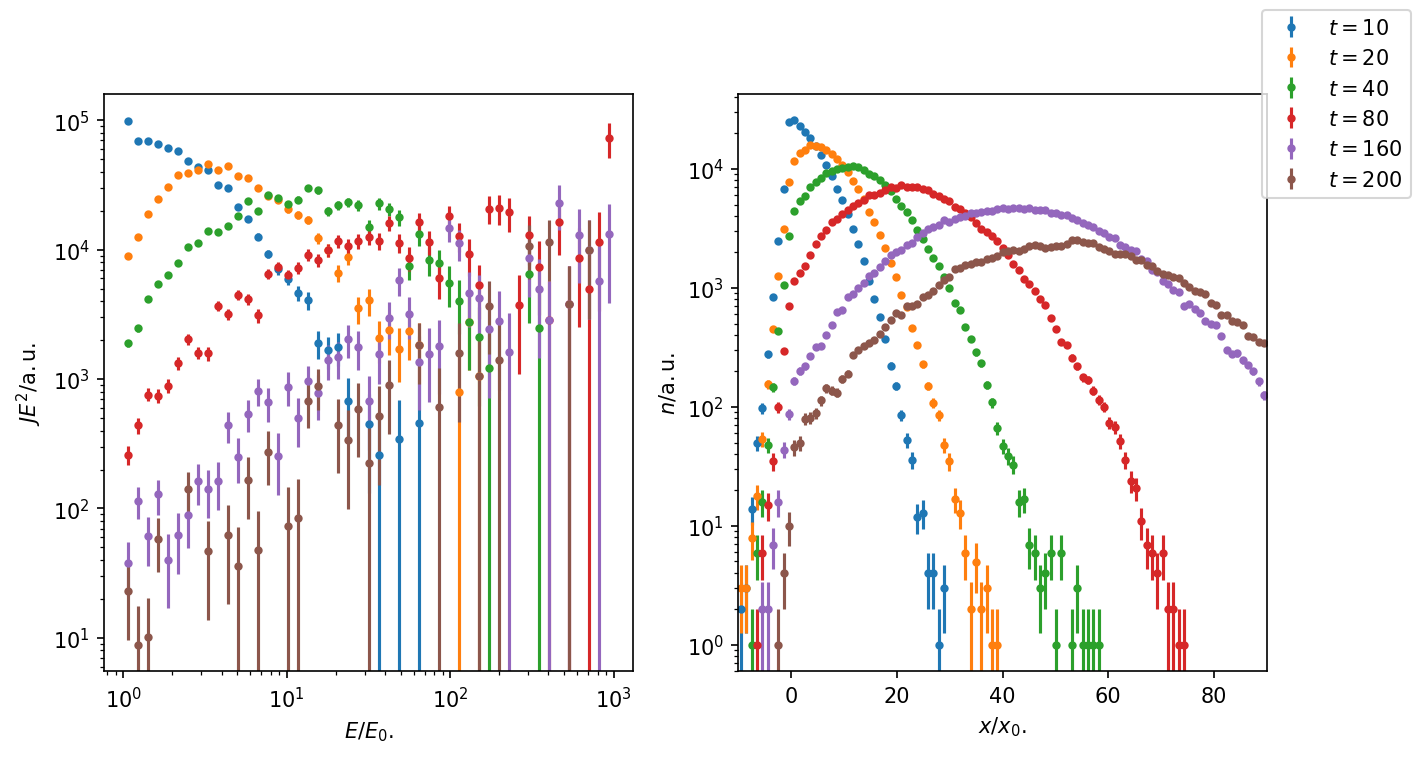

In [6]:
E_bins = 10**np.linspace(0, 3, 50)
x_bins = np.linspace(-10, 90, 100)
times = [10, 20, 40, 80, 160, 200]
dt = 10

fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 150)

for i in range(len(times)):

    #energy-spectrum at the shock:
    J, dJ, bin_center = energy_spectrum(df.loc[(df['X'] > 0) & (df['X'] < 2) & (df['T'] > times[i] - dt) & (df['T'] < times[i] + dt)], E_bins)
    #number-density (integrated over energy):
    N, dN, xbin_center = number_density(df.loc[(df['T'] > times[i] - dt) & (df['T'] < times[i] + dt)], x_bins)

    axs[0].errorbar(bin_center, J*bin_center**2, yerr = dJ*bin_center**2, marker = '.', linestyle = '',label = r'$t = %i$' %times[i])
    axs[1].errorbar(xbin_center, N, yerr = dN, marker = '.', linestyle = '',)
 

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$E/E_0$.")
axs[0].set_ylabel(r"$JE^2/\mathrm{a.u.}$")

axs[1].set_xlim(-10, 90 )
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$x/x_0$.")
axs[1].set_ylabel(r"$n/\mathrm{a.u.}$")
fig.legend()
plt.show()

Figure 1: With time, particles reach higher energy as they repeatedly cross the shock front. However, only few particles are still close to the shock at later times. The downstream number density shows the typical solution for the diffusion-advection eq. over time. Only few particles make it upstream against the advective flow. 

### Approximating the Stationary Solution

In order to obtain the well-known $-2$ power-law, continuous injection of particles at the shock must be considered. This can be approximated by summing over the "time snaps" we plotted before. 

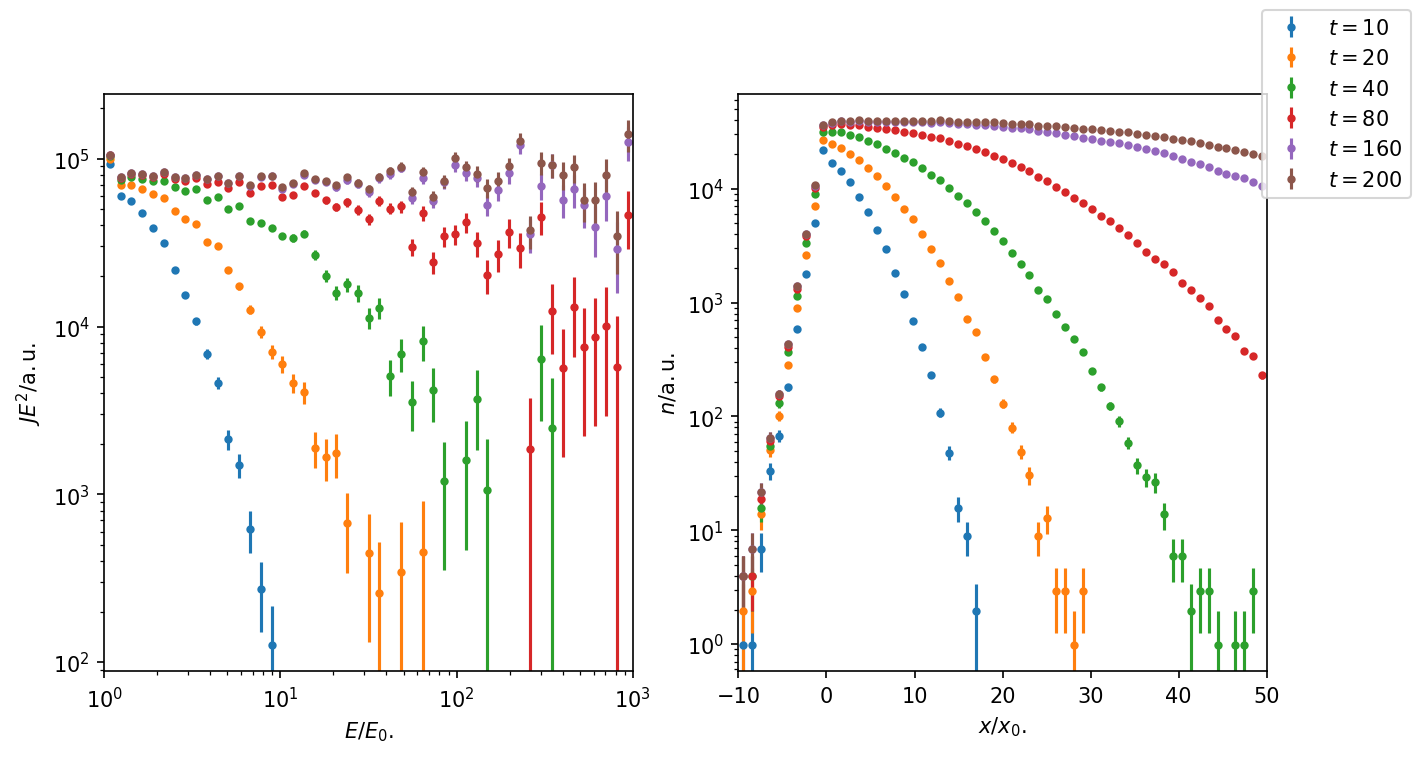

In [7]:
E_bins = 10**np.linspace(0, 3, 50)
x_bins = np.linspace(-10, 50, 60)
times = [10, 20, 40, 80, 160, 200]

fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 150)

for i in range(len(times)):
    
    #energy-spectrum at the shock - take all times <= t into account:
    J, dJ, bin_center = energy_spectrum(df.loc[(df['X'] > 0) & (df['X'] < 2) & (df['T'] <= times[i])], E_bins)
    #number-density (integrated over energy) - take all times <= t into account:
    N, dN, xbin_center = number_density(df.loc[(df['T'] <= times[i])], x_bins)

    axs[0].errorbar(bin_center, J*bin_center**2, yerr = dJ*bin_center**2, marker = '.', linestyle = '',label = r'$t = %i$' %times[i])
    axs[1].errorbar(xbin_center, N, yerr = dN, marker = '.', linestyle = '',)
 

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$E/E_0$.")
axs[0].set_ylabel(r"$JE^2/\mathrm{a.u.}$")
axs[0].set_xlim(1, 10**3)

axs[1].set_xlim(-10, 50 )
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$x/x_0$.")
axs[1].set_ylabel(r"$n/\mathrm{a.u.}$")

fig.legend()
plt.show()

Figure 2: The energy spectrum shows the expected spectral slope $s = -2$, when sufficiently many 'time snaps' are taken into account at late times. For $E < 10 E_0$ the stationary solution is reached at time $t = 160$ at the shock. The same is visible for the number density. 

Assuming that the shock got active at time $t = 0$, the plot shows the time-evolution of the energy-spectrum and number density. 

### Increasing the Statistics at High Energies: Candidate Splitting

Only a fraction of simulated pseudo-particles reaches high energy. This leads to bad statistics above $\approx E = 10^2 E_0$ in Figure 2. For instance, the exponential cut-off is not visible. 

Increasing the number $N$ of simulated particles, lead to better statistics, however a lot of simulation time is wasted on the lower energies. Instead an importance sampling method can be used, by splitting pseudo-particles in copies, once they cross energy bins. This is done by the *CandidateSplitting* module

In [8]:
#Candidate Splitting:
spectral_index = -2 #expected spectral index 
E_min = 10*E0 #minimal energy for splitting
factor = 5  #number of energy bins/maximal splitting
splitting = CandidateSplitting(spectral_index, E_min, factor)

In [9]:
#Simulation

file = "SimpleDSA_splitting.txt"
outTime = TextOutput(file)
outTime.setEnergyScale(TeV)
outTime.setLengthScale(meter)
outTime.disableAll()
outTime.enable(Output.TrajectoryLengthColumn)
outTime.enable(Output.CurrentEnergyColumn)
outTime.enable(Output.CurrentPositionColumn)
outTime.enable(Output.WeightColumn)

obsTime = Observer()
obsTime.add(ObserverTimeEvolution(T_min*c_light, T_max*c_light, n_time, False)) 
obsTime.onDetection(outTime)
obsTime.setDeactivateOnDetection(False)


m = ModuleList()
m.add(diffSDE)
m.add(ac)
m.add(obsTime)
m.add(maxTra)
m.add(splitting)
m.setShowProgress(True)
m.run(source, N_cand)
outTime.close()

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Fri Nov  3 10:13:16 2023 : [ Finished ] 100%    Needed: 00:00:41  - Finished at Fri Nov  3 10:13:57 2023


In [10]:
file = "SimpleDSA_splitting.txt"
columns = ['D', 'E', 'X', 'Y', 'Z', 'W']
df = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df["T"] = df["D"]/(c_light)

(0.03125, 1.0)

/var/folders/hm/8552yhb509l530c14llpb1ym0000gn/T/ipykernel_90855/3921811185.py:16: RuntimeWarning: invalid value encountered in divide
  dJ = J/np.sqrt(H[0])
/var/folders/hm/8552yhb509l530c14llpb1ym0000gn/T/ipykernel_90855/3921811185.py:38: RuntimeWarning: invalid value encountered in divide
  dN = N/np.sqrt(H[0])


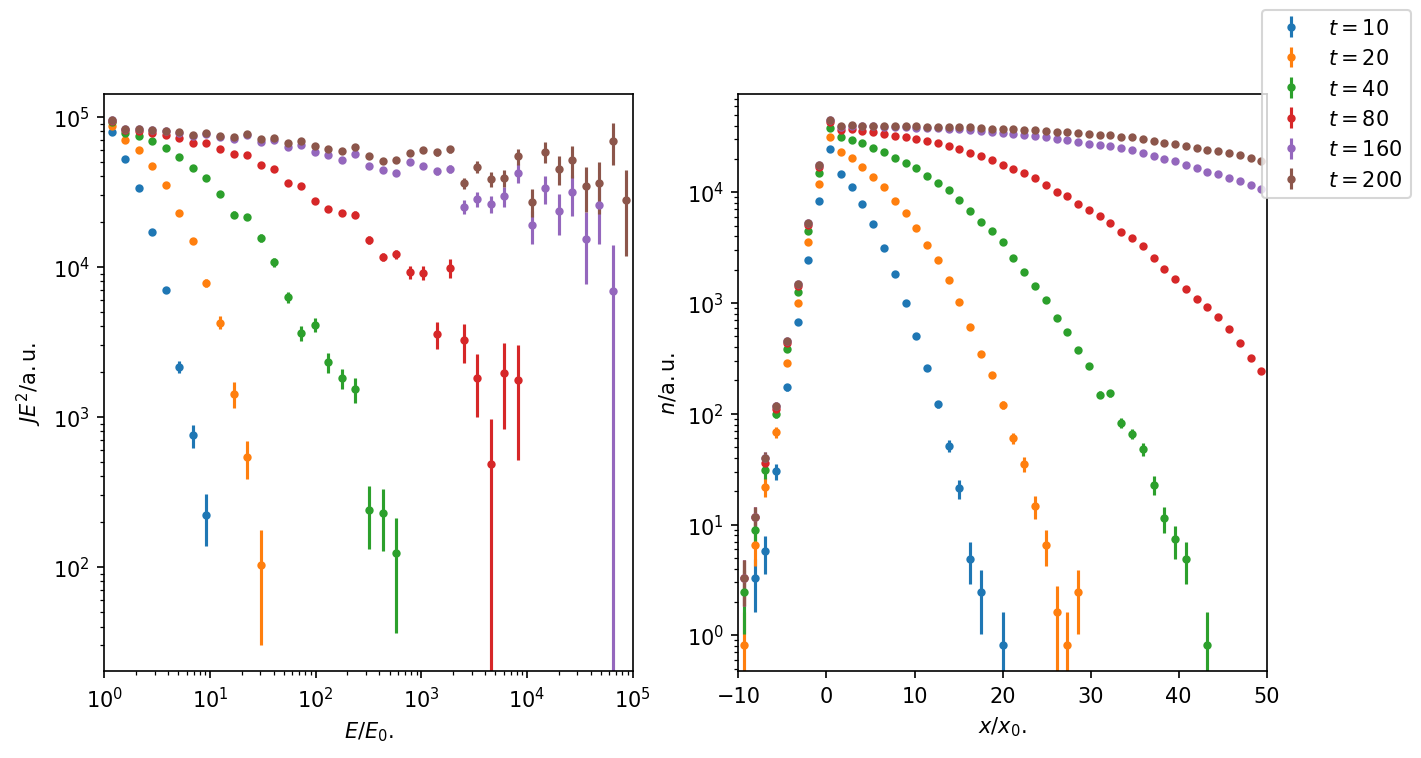

In [11]:
E_bins = 10**np.linspace(0, 5, 40)
x_bins = np.linspace(-10, 50, 60)
times = [10, 20, 40, 80, 160, 200]

fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 150)

for i in range(len(times)):
    
    #energy-spectrum at the shock - take all times <= t into account:
    #histogram is now weighted accordingly
    J, dJ, bin_center = energy_spectrum(df.loc[(df['X'] > 0) & (df['X'] < 2) & (df['T'] <= times[i])], E_bins, weighted = True)
    #number-density (integrated over energy) - take all times <= t into account:
    #histogram is now weighted accordingly
    N, dN, xbin_center = number_density(df.loc[(df['T'] <= times[i])], x_bins, weighted = True)

    axs[0].errorbar(bin_center, J*bin_center**2, yerr = dJ*bin_center**2, marker = '.', linestyle = '',label = r'$t = %i$' %times[i])
    axs[1].errorbar(xbin_center, N, yerr = dN, marker = '.', linestyle = '',)
 

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$E/E_0$.")
axs[0].set_ylabel(r"$JE^2/\mathrm{a.u.}$")
axs[0].set_xlim(1, 10**5)

axs[1].set_xlim(-10, 50 )
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$x/x_0$.")
axs[1].set_ylabel(r"$n/\mathrm{a.u.}$")

fig.legend()
plt.show()

Figure 3: Time evolution of energy-spectrum and number density with CandidateSplitting. The energy-sepctrum reaches higher energies, exponential cut-off at higher energies is now visible. 

### Energy-dependent Diffusion Coefficients

Energy-dependent Diffusion with $\kappa \propto (E/E_0)^{\alpha}, \alpha > 0$ leads to higher diffusion with over time with particles reaching higher energies. This slows down the acceleration over time and leads to a maximal energy that can be reached at the shock. 

In [12]:
alpha = 1
diffSDE.setAlpha(alpha)
scale = TeV/(4*GeV)**alpha
diffSDE.setScale(kappa/(6.1*10**24)/scale) #scaling in DiffusionSDE: kappa = scale * (6.1*10**24) * (R/4GV)^alpha

In [13]:
#Simulation

file = "SimpleDSA_energydependent.txt"
outTime = TextOutput(file)
outTime.setEnergyScale(TeV)
outTime.setLengthScale(meter)
outTime.disableAll()
outTime.enable(Output.TrajectoryLengthColumn)
outTime.enable(Output.CurrentEnergyColumn)
outTime.enable(Output.CurrentPositionColumn)
outTime.enable(Output.WeightColumn)

obsTime = Observer()
obsTime.add(ObserverTimeEvolution(T_min*c_light, T_max*c_light, n_time, False)) 
obsTime.onDetection(outTime)
obsTime.setDeactivateOnDetection(False)


m = ModuleList()
m.add(diffSDE)
m.add(ac)
m.add(obsTime)
m.add(maxTra)
m.add(splitting)
m.setShowProgress(True)
m.run(source, N_cand)
outTime.close()

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Fri Nov  3 10:13:59 2023 : [ Finished ] 100%    Needed: 00:00:38  - Finished at Fri Nov  3 10:14:37 2023


In [14]:
columns = ['D', 'E', 'X', 'Y', 'Z', 'W']
file = "SimpleDSA_energydependent.txt"
df = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df["T"] = df["D"]/(c_light)

/var/folders/hm/8552yhb509l530c14llpb1ym0000gn/T/ipykernel_90855/3921811185.py:16: RuntimeWarning: invalid value encountered in divide
  dJ = J/np.sqrt(H[0])
/var/folders/hm/8552yhb509l530c14llpb1ym0000gn/T/ipykernel_90855/3921811185.py:38: RuntimeWarning: invalid value encountered in divide
  dN = N/np.sqrt(H[0])


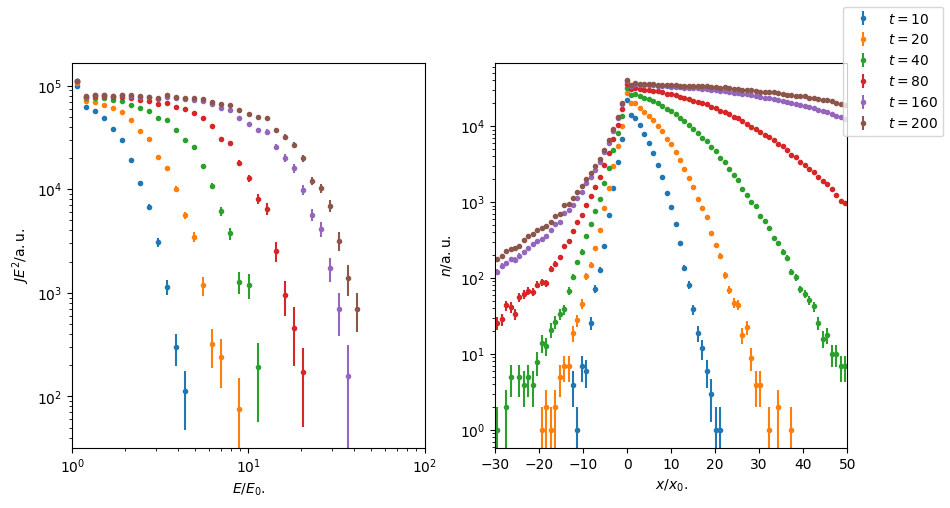

In [15]:
E_bins = 10**np.linspace(0, 2, 40)
x_bins = np.linspace(-30, 50, 80)
times = [10, 20, 40, 80, 160, 200]

fig, axs = plt.subplots(1,2, figsize = (10,5))

for i in range(len(times)):
    
    #energy-spectrum at the shock - take all times <= t into account:
    #histogram is now weighted accordingly
    J, dJ, bin_center = energy_spectrum(df.loc[(df['X'] > 0) & (df['X'] < 2) & (df['T'] <= times[i])], E_bins, weighted = True)
    #number-density (integrated over energy) - take all times <= t into account:
    #histogram is now weighted accordingly
    N, dN, xbin_center = number_density(df.loc[(df['T'] <= times[i])], x_bins, weighted = True)

    axs[0].errorbar(bin_center, J*bin_center**2, yerr = dJ*bin_center**2, marker = '.', linestyle = '',label = r'$t = %i$' %times[i])
    axs[1].errorbar(xbin_center, N, yerr = dN, marker = '.', linestyle = '',)
 

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r"$E/E_0$.")
axs[0].set_ylabel(r"$JE^2/\mathrm{a.u.}$")
axs[0].set_xlim(1, 10**2)

axs[1].set_xlim(-30, 50 )
axs[1].set_yscale('log')
axs[1].set_xlabel(r"$x/x_0$.")
axs[1].set_ylabel(r"$n/\mathrm{a.u.}$")

fig.legend()
plt.show()

Figure 4: With energy-dependent diffusion, acceleration slows down over time and comparede to Figure 3 only a fraction of energy is reached at $t = 200$. With higher diffusion at high energy, more particles make it in the upstream region with increasing time

### Acceleration Time Scale


From the previous simulations, the mean acceleration time scale can be calculated and compared with analytical predicitons:

In [16]:
kappa_up = kappa
kappa_down = kappa
v_down = 1./compression

t_acc = 3./(v_up - v_down) * (kappa_up/v_up + kappa_down/v_down)

def mean_acceleration_time(p, tacc, alpha, p0 = 1):
    #returns the mean acceleration time to reach momentum p
    #depends on diffusion coefficient, advection field, given by tacc
    #and on energy-dependence of the diffusion coefficient fiven by alpha
    #see, e.g. Drury, 1983 

    if alpha == 0:
        return tacc * np.log(p/p0)
    elif alpha == 1:
        return (p/p0 - 1)*tacc
    elif alpha == 2:
        return ((p/p0)**2 - 1) * tacc/2
    else:
        print("Unknown alpha: alpha = 0,1,2")

def approximate_acceleration_time(df):
    #calculate mean time to accelerate up to energy E
    #given by dataframe df
    #returns weighted mean time, error of the mean
    if df['W'].sum() > 0:
        average = np.average(df['T'], weights = df['W'])
        error = (np.sqrt(np.average((df['T']-average)*(df['T']-average), weights = df['W'])/df['W'].sum())) 
        return average, error
    else:
        return 0, 0




In [17]:
columns = ['D', 'E', 'X', 'Y', 'Z', 'W']
#energy-independent:
file = "SimpleDSA_splitting.txt"
df0 = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df0["T"] = df0["D"]/(c_light)
#energy-dependent:
file = "SimpleDSA_energydependent.txt"
df1 = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df1["T"] = df1["D"]/(c_light)

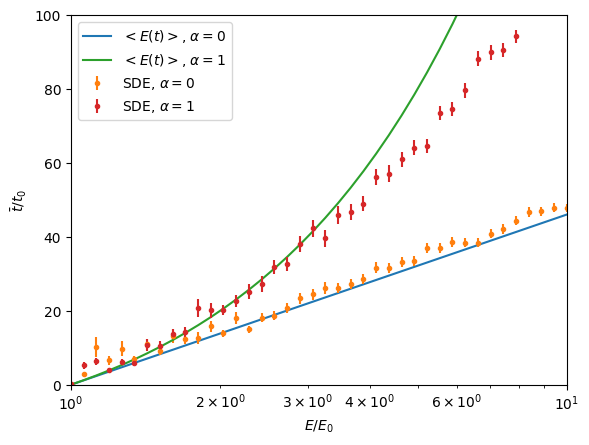

In [18]:

Energy = 10**np.linspace(0, 1, 40)
dEnergy = 10**np.linspace(-3, 0, 40)

avTime0 = []
errTime0 = []
avTime1 = []
errTime1 = []
plot0 = []
plot1 = []

for i in range(len(Energy)):
    E = Energy[i]
    dE = dEnergy[i]

    average, error = approximate_acceleration_time(df0.loc[(df0['X']> 0) & (df0['X'] < 1) & (df0['E'] <= E+dE) & (df0['E'] > E-dE)])
    if average > 0:
        plot0.append(E)
        avTime0.append(average) 
        errTime0.append(error)

    average, error = approximate_acceleration_time(df1.loc[(df1['X']> 0) & (df1['X'] < 1) & (df1['E'] <= E+dE) & (df1['E'] > E-dE)])
    if average > 0:
        plot1.append(E)
        avTime1.append(average) 
        errTime1.append(error)


plt.plot(Energy, mean_acceleration_time(Energy, t_acc, 0), label = r'$<E(t)>$, $\alpha = 0$')
plt.errorbar(plot0, avTime0, errTime0, linestyle = '', marker = '.',label = r'SDE, $\alpha = 0$')

plt.plot(Energy, mean_acceleration_time(Energy, t_acc, 1),  label = r'$<E(t)>$, $\alpha = 1$')
plt.errorbar(plot1, avTime1, errTime1, linestyle = '', marker = '.',label = r'SDE, $\alpha = 1$')

plt.xscale('log')
plt.ylabel(r'$\bar{t}/t_0$')
plt.xlabel(r'$E/E_0$')
plt.ylim([0, 100])
plt.xlim([1, 10])
plt.legend()
plt.show()

Figure 5: Mean acceleration time to reach energy $E/E_0$. At high energies, mean acceleration time of the CRPropa simulation deviates from the prediciton. This is due to finite simulation time $T = 200$. 